# Model

In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json_tricks as json
import copy

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import stein
import train
import kernels
from svgd import SVGD

from jax.experimental import optimizers

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Vanilla ARD

In [15]:
conf = copy.deepcopy(config.config)
conf["kernel"]["architecture"] = "Vanilla"
conf["train_kernel"]["ksd_steps"] = 0
conf["train_kernel"]["svgd_steps"] = 1
conf["train_kernel"]["n_iter"] = config.config["train_kernel"]["n_iter"] // conf["train_kernel"]["svgd_steps"]

In [16]:
svgd_vanilla = SVGD(**config.get_svgd_args(conf))

In [17]:
# x = np.array([1,2.])
# p = svgd_vanilla.kernel.init(rkey, x, x)
# p

In [18]:
kernel_params_vanilla, rundata_vanilla = svgd_vanilla.train_kernel(**config.get_train_args(conf))

  0%|          | 0/40 [00:00<?, ?it/s]/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [19]:
print(metrics.compute_final_metrics(rundata_vanilla["particles"], svgd_vanilla))
comparison_sample = svgd_vanilla.target.sample(1000)
print(metrics.compute_final_metrics(comparison_sample, svgd_vanilla))

{'emd': DeviceArray(0.6315393, dtype=float32), 'sinkhorn_divergence': array(0.37107141), 'ksd': DeviceArray(0.00534328, dtype=float32), 'se_mean': DeviceArray(0.11549325, dtype=float32), 'se_var': DeviceArray(0.06317104, dtype=float32)}
{'emd': DeviceArray(0.30253756, dtype=float32), 'sinkhorn_divergence': array(0.06361727), 'ksd': DeviceArray(0.00123241, dtype=float32), 'se_mean': DeviceArray(0.00034618, dtype=float32), 'se_var': DeviceArray(0.01818554, dtype=float32)}


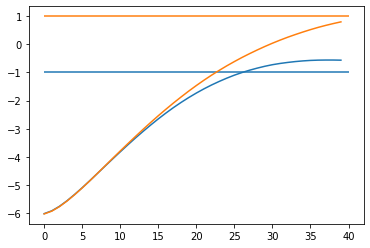

In [20]:
colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

mean = onp.array(rundata_vanilla["mean"])
tru_mean = conf["svgd"]["target_args"][0]

_ = plt.plot(mean)
_ = plt.hlines(tru_mean, 0, 40, colors=colorcycle)

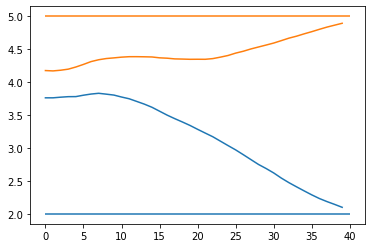

In [21]:
tru_var = conf["svgd"]["target_args"][1]

var = onp.array(rundata_vanilla["var"])
_ = plt.plot(var)
_ = plt.hlines(tru_var, 0, 40, colors=colorcycle)

In [22]:
rundata_vanilla["ksd_after_kernel_update"]

DeviceArray([], dtype=float32)

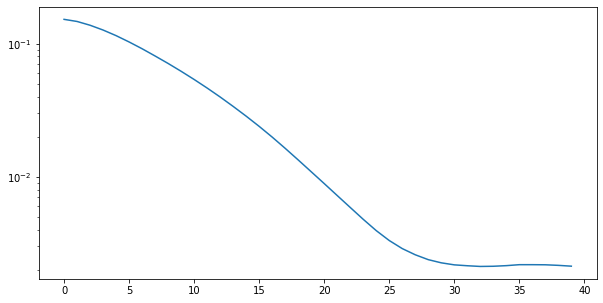

In [23]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(rundata_vanilla["ksd_after_svgd_update"])
ax.set_yscale("log")

# MLP Kernel

In [32]:
conf_mlp = copy.deepcopy(config.config)

conf_mlp["kernel"]["architecture"] = "MLP"

conf_mlp["kernel"]["architecture"] = "MLP"
conf_mlp["kernel"]["layers"] = [2, 2, 2]
conf_mlp["train_kernel"]["ksd_steps"] = 1
conf_mlp["train_kernel"]["svgd_steps"] = 1
conf_mlp["train_kernel"]["n_iter"] = config.config["train_kernel"]["n_iter"] // conf_mlp["train_kernel"]["svgd_steps"]

In [33]:
svgd_mlp = SVGD(**config.get_svgd_args(conf_mlp))

In [34]:
kernel_params_mlp, rundata_mlp = svgd_mlp.train_kernel(**config.get_train_args(conf_mlp))

  0%|          | 0/40 [00:00<?, ?it/s]/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [35]:
print(metrics.compute_final_metrics(rundata_mlp["particles"], svgd_mlp))
comparison_sample = svgd_mlp.target.sample(1000)
print(metrics.compute_final_metrics(comparison_sample, svgd_mlp))

{'emd': DeviceArray(0.9555937, dtype=float32), 'sinkhorn_divergence': array(0.88304461), 'ksd': DeviceArray(0.00932255, dtype=float32), 'se_mean': DeviceArray(0.26055658, dtype=float32), 'se_var': DeviceArray(0.9663967, dtype=float32)}
{'emd': DeviceArray(0.30253756, dtype=float32), 'sinkhorn_divergence': array(0.06361727), 'ksd': DeviceArray(0.00123241, dtype=float32), 'se_mean': DeviceArray(0.00034618, dtype=float32), 'se_var': DeviceArray(0.01818554, dtype=float32)}


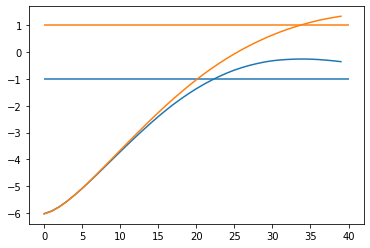

In [40]:
colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

mean = onp.array(rundata_mlp["mean"])
tru_mean = conf_mlp["svgd"]["target_args"][0]

_ = plt.plot(mean)
_ = plt.hlines(tru_mean, 0, 40, colors=colorcycle)

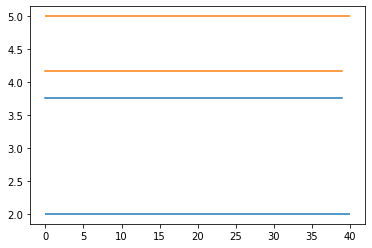

In [41]:
tru_var = conf_mlp["svgd"]["target_args"][1]

var = onp.array(rundata_mlp["var"])
_ = plt.plot(var)
_ = plt.hlines(tru_var, 0, 40, colors=colorcycle)

In [38]:
n_iter = conf_mlp["train_kernel"]["n_iter"]
# ksd_kernel = np.split(rundata_mlp["ksd_after_kernel_update"], n_iter)
# ksd_svgd = np.split(rundata_mlp["ksd_after_svgd_update"], n_iter)
ksd_kernel = rundata_mlp["ksd_after_kernel_update"]

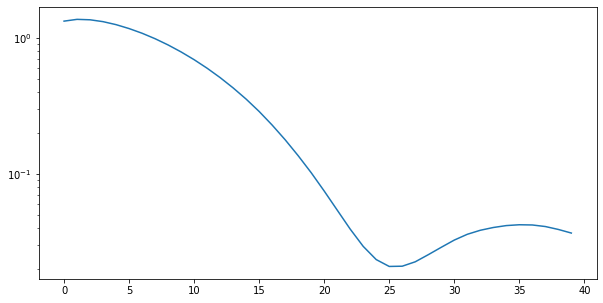

In [39]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(ksd_kernel)
#     ax.plot(ksdss)


# for i, ksds in enumerate(ksd_kernel):
#     idx = range(40*i, 40*i+20)
# #     print("k range:", idx)
#     ax.plot(idx, ksds, ".b")

# for i, ksds in enumerate(ksd_svgd):
#     start = 40*(i+1) - 20
#     stop = 40*(i+1)
#     step = 5
#     idx = range(start, stop, step)
# #     print("s range:", idx)
#     ax.plot(idx, ksds, ".r")

ax.set_yscale("log")